# Data Exploration. Attack-Defend Game

In [ ]:
# import libraries
import pandas as pd
import os
import torch
from torch_geometric.data import Data
import networkx as nx
import matplotlib.pyplot as plt
from torch_geometric.utils import to_networkx
import matplotlib.colors as mcolors

### 1. Collect Data
Collect data from data source: each day of the week has a different kind of attack type

NOTE: The dataset used for now is Friday-WorkingHours-Afternoon-DDos.pcap_ISCX due the amount of data

In [ ]:
# Init the base df
base_df = pd.DataFrame()
# init folder where is data source
folder_path = './data/daily'
# list of reports to filter
reports_to_use = [
    'Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv', 
    'Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv',
    'Friday-WorkingHours-Morning.pcap_ISCX.csv',
    'Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv',
    'Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv',
    'Wednesday-workingHours.pcap_ISCX.csv',
    'Tuesday-WorkingHours.pcap_ISCX.csv',
    'Monday-WorkingHours.pcap_ISCX.csv'
]
# For each CSV file in daily report folder read it and concatenate to base df
for filename in os.listdir(folder_path):
    if filename.endswith(".csv"):
        # check if is in reports to use
        if filename not in reports_to_use:
            continue

        # Prints only text file present in My Folder
        print('read report filename (.csv): ', filename)
        file_path = os.path.join(folder_path, filename)
        try:
            # read day report df 
            day_report_df = pd.read_csv(file_path)
        except Exception as e:
            # read day report df using latin encoding
            day_report_df = pd.read_csv(file_path, encoding='latin1')
        finally:
            # rename columns, remove blank spaces and replace them by '_'
            columns_dict = {}
            for column_report in day_report_df.columns:
                columns_dict[column_report] = column_report.strip().replace(' ', '_').lower()
            day_report_df.rename(columns=columns_dict, inplace=True)
            # add day of week columns
            day_report_df['source'] = filename.replace('.csv', '')
            # concatenate report
            base_df = pd.concat([base_df, day_report_df], ignore_index=True)
            
print(f"shape: {base_df.shape}")

In [ ]:
print(f"kind of attacks: {base_df['label'].unique()}")

### 2. Clean data
Clean data set

remove duplicated rows

In [ ]:
# remove duplicated
base_df.drop_duplicates(inplace=True)
print(f"new shape: {base_df.shape}")

### 3. Preprocess
Build the servers (nodes) and their features. Build the communication (edges) and the features. 

Servers dataset (nodes):
- Get the unique server ip.
- For each server define if it's an attacker or benign server

In [ ]:
# strip and format ip columns
base_df['source_ip'] = base_df['source_ip'].str.strip()
base_df['destination_ip'] = base_df['destination_ip'].str.strip()
# get unique servers ip
source_ip = set(base_df['source_ip'].unique())
destination_ip = set(base_df['destination_ip'].unique())
# merge source and destination ips
all_ips = source_ip | destination_ip
print(f"there are {len(source_ip)} source servers ips")
print(f"there are {len(destination_ip)} destination servers ips")
print(f"there are {len(all_ips)} total servers ips")

In [ ]:
# filter the attackers and type of attacks
server_attacker_df = base_df.loc[base_df['label'] != 'BENIGN'].groupby(by='source_ip').agg(attacks_types=('label', lambda x: ','.join(x.unique()))).reset_index()
# rename ip column
server_attacker_df.rename(columns={'source_ip': 'ip'}, inplace=True)
server_attacker_df

In [ ]:
# filter servers attacked, the victims. get the number of attacks and the attacker ip list and type of attacks list
server_attacker_ips = server_attacker_df['ip'].tolist()
server_victims_df = base_df.loc[(base_df['source_ip'].isin(server_attacker_ips)) & (base_df['label'] != 'BENIGN')].groupby(by='destination_ip').agg(n_attacks=('label', lambda x: len(x)), attacker_ips=('source_ip', lambda x: ','.join(x.unique())), attack_types=('label', lambda x: ','.join(x.unique()))).reset_index()
# rename ip column
server_victims_df.rename(columns={'destination_ip': 'ip'}, inplace=True)
server_victims_df

In [ ]:
# get the direct collateral victims, serves connected directly with the victims, doesn't matter the communication direction
server_victims_ips = server_victims_df['ip'].tolist()
# get receiver collateral victims, collateral victims where the direct victim send request to the collateral victim
server_collateral_victims_receivers_df = base_df.loc[base_df['source_ip'].isin(server_victims_ips)].groupby(by='destination_ip').agg(n_interactions=('label', lambda x: len(x))).reset_index()
server_collateral_victims_receivers_df.sort_values(by='n_interactions', ascending=False)

In [ ]:
# get requester collateral victims, collateral victims where the direct victim receive request from the collateral victim
server_collateral_victims_requesters_df = base_df.loc[base_df['destination_ip'].isin(server_victims_ips)].groupby(by='source_ip').agg(n_interactions=('label', lambda x: len(x))).reset_index()
server_collateral_victims_requesters_df

Init node features. servers features, the unique one use is the target (attacker benign)

In [ ]:
# Build servers data
servers_df = pd.DataFrame(all_ips, columns=['ip'])
servers_df['type'] = 0
# locate and update the attackers servers (nodes)
servers_df.loc[servers_df['type'].isin(server_attacker_df['ip'].tolist()), 'type'] = 1
# Add node index by order
servers_df['ip_index'] = servers_df.index
servers_df

Define edges. Server connections. The communication has a direction, one server send the request and other one received and may 
attacker_df
Pytorch only accept numbers, in order to use the same (similar) source ip and destination ip, the number to use is the same ip address without dots (ex. '172.16.0.1' => 1721601)

In [ ]:
# Extract the source and target node pairs for directed edges, use the ip_index to define destination and source
base_df = base_df.merge(servers_df[['ip', 'ip_index']], left_on='source_ip', right_on='ip', how='left')
base_df.rename(columns={'ip_index': 'source_ip_index'}, inplace=True)
base_df.drop(columns=['ip'], inplace=True)
base_df = base_df.merge(servers_df[['ip', 'ip_index']], left_on='destination_ip', right_on='ip', how='left')
base_df.rename(columns={'ip_index': 'destination_ip_index'}, inplace=True)
base_df.drop(columns=['ip'], inplace=True)

In [ ]:
# create the directional edges
edge_index = torch.tensor([base_df['source_ip_index'].tolist(), base_df['destination_ip_index'].tolist()], dtype=torch.long)
edge_index

Filter relevant columns

In [ ]:
edges_features_columns = [
    # a protocol is a set of rules for formatting and processing data. Network protocols are like a common language for computers. 
    'protocol',
    # port number on the sending device (the source) that initiated the connection
    'source_port',
    # port number on the receiving device (the destination) where the data is being sent
    'destination_port',
    # refers to the total time a flow (a sequence of packets exchanged between a source and a destination) lasts, from the moment the first packet is sent to the moment the last packet is received
    'flow_duration',
    # FWD Forward data
    # forward packages data. basic metrics about pakages sent from source to destination 
    'total_fwd_packets',
    'total_length_of_fwd_packets',
    'fwd_packet_length_max',
    'fwd_packet_length_min',
    'fwd_packet_length_mean',
    'fwd_packet_length_std',
    # IAT: Inter-Arrival Time (IAT) of forward packets in a network flow. IAT (Inter-Arrival Time) is the time difference between the arrival of consecutive packets in a flow
    'fwd_iat_total',
    'fwd_iat_mean',
    'fwd_iat_std',
    'fwd_iat_max',
    'fwd_iat_min',
    # PSH Flags: Fwd PSH Flags metric refers to the count of TCP packets with the PSH (Push) flag set in the forward direction
    'fwd_psh_flags',
    # URG Flags: Fwd URG Flags metric refers to the count of TCP packets with the URG (Urgent) flag set in the forward direction
    'fwd_urg_flags',
    # header length: Fwd Header Length refers to the total length of the headers in the packets that are traveling in the forward direction 
    'fwd_header_length',
    # Packets/s: number of forward packages
    'fwd_packets/s',
    # bytes info 
    'fwd_avg_bytes/bulk',
    'fwd_avg_packets/bulk',
    'fwd_avg_bulk_rate',
    # BWD backward data
    # backward packages data. basic metrics about pakages sent from source to destination 
    'total_backward_packets',
    'total_length_of_bwd_packets',
    'bwd_packet_length_max',
    'bwd_packet_length_min',
    'bwd_packet_length_mean',
    'bwd_packet_length_std',
    # IAT: Inter-Arrival Time (IAT) of backward packets in a network flow. IAT (Inter-Arrival Time) is the time difference between the arrival of consecutive packets in a flow
    'bwd_iat_total',
    'bwd_iat_mean',
    'bwd_iat_std',
    'bwd_iat_max',
    'bwd_iat_min',
    # PSH Flags: bwd PSH Flags metric refers to the count of TCP packets with the PSH (Push) flag set in the backward direction
    'bwd_psh_flags',
    # URG Flags: bwd URG Flags metric refers to the count of TCP packets with the URG (Urgent) flag set in the backward direction
    'bwd_urg_flags',
    # header length: bwd Header Length refers to the total length of the headers in the packets that are traveling in the backward direction 
    'bwd_header_length',
    # Packets/s: number of backward packages
    'bwd_packets/s',
    # bytes info 
    'bwd_avg_bytes/bulk',
    'bwd_avg_packets/bulk',
    'bwd_avg_bulk_rate',
    # Global metrics
    # FIN Flag: number of packets in a network flow that have the FIN (Finish) flag set.
    'fin_flag_count',
    # SYN Flag: number of packets in a network flow that have the SYN (Synchronize) flag set.
    'syn_flag_count',
    # SYN Flag: number of packets in a network flow that have the RST (Reset) flag set.
    'rst_flag_count',
    # SYN Flag: number of packets in a network flow that have the PSH (Push) flag set.
    'psh_flag_count',
    # SYN Flag: number of packets in a network flow that have the ACK (Acknowledgment) flag set.
    'ack_flag_count',
    # Common Weakness Enumeration, which is a category system for software vulnerabilities and weaknesses.
    'cwe_flag_count',
    # ECE Flag Count refers to the number of packets in a network flow that have the ECE (Explicit Congestion Notification Echo) flag set.
    'ece_flag_count',
]

Init edge features. servers communication features

features selected to map attacks 

In [ ]:
# Init edge features
edge_features = torch.tensor(base_df[edges_features_columns].values, dtype=torch.float)
edge_features

Create graph object

In [ ]:
# Create PyG Data object
data = Data(edge_index=edge_index, edge_attr=edge_features, num_nodes=servers_df.shape[0])
# Convert the PyG data to a NetworkX graph for visualization
G = to_networkx(data, edge_attrs=['edge_attr'], to_undirected=False)

### 4. Plot Graph
Plot results 


Plot the servers network graph 

In [ ]:
# Plot the graph with node IDs
plt.figure(figsize=(8, 8))
nx.draw(G, with_labels=False, node_color='skyblue', node_size=10, edge_color='gray', font_size=15, font_weight='bold')
plt.title('Server Network Attack-Defend Game')
plt.show()

Plot Server Network, add color to attack and victim nodes, the same apply for edges if they are attacks or benign

Add color to collateral victims too

In [ ]:
# copy base dataset and filter the relevant interaction: if all interactions are BENIGN, or if at least one interaction is not BENIGN
base_last_interaction_df = base_df.copy()
base_last_interaction_df = base_last_interaction_df.groupby(by=['source_ip_index', 'destination_ip_index']).agg(interation_type=('label', lambda x: any(filter(lambda i: i != 'BENIGN', x)))).reset_index()
base_last_interaction_df = base_last_interaction_df.sort_values(by='interation_type').reset_index(drop=True)
base_last_interaction_df

In [ ]:
base_last_interaction_df.loc[base_last_interaction_df['interation_type']]

In [ ]:
edge_last_interaction_index = torch.tensor([base_last_interaction_df['source_ip_index'].tolist(), base_last_interaction_df['destination_ip_index'].tolist()], dtype=torch.long)
edge_last_interaction_index

In [ ]:
# Create PyG Data object
last_interaction_data = Data(edge_index=edge_last_interaction_index, num_nodes=servers_df.shape[0])
# Convert the PyG data to a NetworkX graph for visualization
G_last_interaction = to_networkx(last_interaction_data, to_undirected=False)

In [ ]:
# Define unique colors for each category using a colormap or a list of colors
unique_interaction_types = list(set(base_last_interaction_df['interation_type'])) 
color_map_interaction_types = dict(zip(unique_interaction_types, mcolors.TABLEAU_COLORS.keys()))

# Edge labels
edge_interation_types = base_last_interaction_df['interation_type'].tolist()

# Map the edge labels to their corresponding color
edge_colors = [color_map_interaction_types[label] for label in edge_interation_types]

In [ ]:
# Map IP addresses to integer node IDs
ip_to_id = {ip: idx for idx, ip in enumerate(pd.concat([base_last_interaction_df['source_ip_index'], base_last_interaction_df['destination_ip_index']]).unique())}

source_ids = base_last_interaction_df['source_ip_index'].map(ip_to_id).tolist()
destination_ids = base_last_interaction_df['destination_ip_index'].map(ip_to_id).tolist()

plt.figure(figsize=(8, 8))
# Get positions for the nodes
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=False, node_color='skyblue', node_size=10, edge_color=edge_colors, width=1, font_size=12, font_weight='bold')

# Annotate the edges with the actual label values
#edge_label_dict = {(source, target): f'{label}' for source, target, label in zip(source_ids, destination_ids, edge_labels)}
#nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_label_dict)

# Add a legend to show which color corresponds to which category
legend_labels = {color_map_interaction_types[label]: label for label in color_map_interaction_types}
handles = [plt.Line2D([0], [0], color=color, lw=1) for color in legend_labels.keys()]
plt.legend(handles, legend_labels.values(), title="Event Attack Category")

plt.title('Server Network Attack-Defend Game. Category Attack colors (edge)')
plt.show()

### 5. Calculate centrality metrics
Apply betweeness centrality and eigenvector centrality

In [ ]:
from graphs_operations.operations import get_betweenness_centrality, get_eigenvector_centrality, get_graph_laplacian

Measures the extent to which a vertex lies on paths between other vertices. 

The business meaning in our case is the key communication servers, they may be good objectives to expand an attack and they are ket towers to defend

In [ ]:
nodes_betweenness_centrality_scores = get_betweenness_centrality(G)
node_centrality = [(servers_df.iloc[node], centrality) for node, centrality in nodes_betweenness_centrality_scores.items()]
node_centrality.sort(key=lambda x: x[1], reverse=True)
pd.DataFrame(node_centrality)

In [ ]:
server_ip = '192.168.10.12'
# server_ip = '192.168.10.5'
server_ip_index = servers_df.loc[servers_df['ip'] == server_ip].index[0]

in_degree = G.in_degree(server_ip_index)
out_degree = G.out_degree(server_ip_index)
print(f"The in-degree of server {server_ip} is: {in_degree}")
print(f"The out-degree of server {server_ip} is: {out_degree}")

Eigenvector centrality is a measure of the influence a node has on a network. 

The business meaning in our case is the influential servers, servers that could generate an influence over others.

In [ ]:
nodes_eigenvector_centrality_scores = get_eigenvector_centrality(G)
node_centrality = [(servers_df.iloc[node], centrality) for node, centrality in nodes_eigenvector_centrality_scores.items()]
node_centrality.sort(key=lambda x: x[1], reverse=True)
pd.DataFrame(node_centrality)

In [ ]:
server_ip = '192.168.10.15'
# server_ip = '192.168.10.5'
server_ip_index = servers_df.loc[servers_df['ip'] == server_ip].index[0]

in_degree = G.in_degree(server_ip_index)
out_degree = G.out_degree(server_ip_index)
print(f"The in-degree of server {server_ip} is: {in_degree}")
print(f"The out-degree of server {server_ip} is: {out_degree}")

Laplacian: Structure of the relations in a graph

In [ ]:
from torch_geometric.utils import to_networkx, get_laplacian
get_laplacian(edge_index)

In [ ]:
server_graph_data_filepath = './data/server_graph_data.pth'
torch.save(data, server_graph_data_filepath)

In [1]:
# import libraries
import pandas as pd
import os
import torch
from torch_geometric.data import Data
import networkx as nx
import matplotlib.pyplot as plt
from torch_geometric.utils import to_networkx
import matplotlib.colors as mcolors

### 1. Collect Data
Collect data from data source: each day of the week has a different kind of attack type

NOTE: The dataset used for now is Friday-WorkingHours-Afternoon-DDos.pcap_ISCX due the amount of data

In [2]:
# Init the base df
base_df = pd.DataFrame()
# init folder where is data source
folder_path = './data/daily'
# list of reports to filter
reports_to_use = [
    'Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv', 
    'Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv',
    'Friday-WorkingHours-Morning.pcap_ISCX.csv',
    'Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv',
    'Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv',
    'Wednesday-workingHours.pcap_ISCX.csv',
    'Tuesday-WorkingHours.pcap_ISCX.csv',
    'Monday-WorkingHours.pcap_ISCX.csv'
]
# For each CSV file in daily report folder read it and concatenate to base df
for filename in os.listdir(folder_path):
    if filename.endswith(".csv"):
        # check if is in reports to use
        if filename not in reports_to_use:
            continue

        # Prints only text file present in My Folder
        print('read report filename (.csv): ', filename)
        file_path = os.path.join(folder_path, filename)
        try:
            # read day report df 
            day_report_df = pd.read_csv(file_path)
        except Exception as e:
            # read day report df using latin encoding
            day_report_df = pd.read_csv(file_path, encoding='latin1')
        finally:
            # rename columns, remove blank spaces and replace them by '_'
            columns_dict = {}
            for column_report in day_report_df.columns:
                columns_dict[column_report] = column_report.strip().replace(' ', '_').lower()
            day_report_df.rename(columns=columns_dict, inplace=True)
            # add day of week columns
            day_report_df['source'] = filename.replace('.csv', '')
            # concatenate report
            base_df = pd.concat([base_df, day_report_df], ignore_index=True)
            
print(f"shape: {base_df.shape}")

read report filename (.csv):  Tuesday-WorkingHours.pcap_ISCX.csv
read report filename (.csv):  Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv
read report filename (.csv):  Wednesday-workingHours.pcap_ISCX.csv
read report filename (.csv):  Monday-WorkingHours.pcap_ISCX.csv
read report filename (.csv):  Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv
read report filename (.csv):  Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv
read report filename (.csv):  Friday-WorkingHours-Morning.pcap_ISCX.csv
read report filename (.csv):  Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv
shape: (2830706, 86)


In [3]:
print(f"kind of attacks: {base_df['label'].unique()}")

kind of attacks: ['BENIGN' 'FTP-Patator' 'SSH-Patator' 'DDoS' 'DoS slowloris'
 'DoS Slowhttptest' 'DoS Hulk' 'DoS GoldenEye' 'Heartbleed'
 'Web Attack \x96 Brute Force' 'Web Attack \x96 XSS'
 'Web Attack \x96 Sql Injection' 'PortScan' 'Bot' 'Infiltration']


### 2. Clean data
Clean data set

remove duplicated rows

In [4]:
# remove duplicated
base_df.drop_duplicates(inplace=True)
print(f"new shape: {base_df.shape}")

new shape: (2830503, 86)


### 3. Preprocess
Build the servers (nodes) and their features. Build the communication (edges) and the features. 

Servers dataset (nodes):
- Get the unique server ip.
- For each server define if it's an attacker or benign server

In [5]:
# strip and format ip columns
base_df['source_ip'] = base_df['source_ip'].str.strip()
base_df['destination_ip'] = base_df['destination_ip'].str.strip()
# get unique servers ip
source_ip = set(base_df['source_ip'].unique())
destination_ip = set(base_df['destination_ip'].unique())
# merge source and destination ips
all_ips = source_ip | destination_ip
print(f"there are {len(source_ip)} source servers ips")
print(f"there are {len(destination_ip)} destination servers ips")
print(f"there are {len(all_ips)} total servers ips")

there are 17005 source servers ips
there are 19112 destination servers ips
there are 19129 total servers ips


In [6]:
# filter the attackers and type of attacks
server_attacker_df = base_df.loc[base_df['label'] != 'BENIGN'].groupby(by='source_ip').agg(attacks_types=('label', lambda x: ','.join(x.unique()))).reset_index()
# rename ip column
server_attacker_df.rename(columns={'source_ip': 'ip'}, inplace=True)
server_attacker_df

,ip,attacks_types
0,172.16.0.1,"FTP-Patator,SSH-Patator,DDoS,DoS slowloris,DoS..."
1,192.168.10.12,Bot
2,192.168.10.14,Bot
3,192.168.10.15,Bot
4,192.168.10.17,Bot
5,192.168.10.5,Bot
6,192.168.10.50,DDoS
7,192.168.10.8,"Bot,Infiltration"
8,192.168.10.9,Bot
9,205.174.165.73,Bot


In [7]:
# filter servers attacked, the victims. get the number of attacks and the attacker ip list and type of attacks list
server_attacker_ips = server_attacker_df['ip'].tolist()
server_victims_df = base_df.loc[(base_df['source_ip'].isin(server_attacker_ips)) & (base_df['label'] != 'BENIGN')].groupby(by='destination_ip').agg(n_attacks=('label', lambda x: len(x)), attacker_ips=('source_ip', lambda x: ','.join(x.unique())), attack_types=('label', lambda x: ','.join(x.unique()))).reset_index()
# rename ip column
server_victims_df.rename(columns={'destination_ip': 'ip'}, inplace=True)
server_victims_df

,ip,n_attacks,attacker_ips,attack_types
0,172.16.0.1,3,192.168.10.50,DDoS
1,192.168.10.14,139,205.174.165.73,Bot
2,192.168.10.15,209,205.174.165.73,Bot
3,192.168.10.5,108,205.174.165.73,Bot
4,192.168.10.50,555629,172.16.0.1,"FTP-Patator,SSH-Patator,DDoS,DoS slowloris,DoS..."
5,192.168.10.51,11,172.16.0.1,Heartbleed
6,192.168.10.8,103,205.174.165.73,Bot
7,192.168.10.9,146,205.174.165.73,Bot
8,205.174.165.73,1293,"192.168.10.9,192.168.10.15,192.168.10.14,192.1...","Bot,Infiltration"
9,52.6.13.28,2,192.168.10.12,Bot


In [8]:
# get the direct collateral victims, serves connected directly with the victims, doesn't matter the communication direction
server_victims_ips = server_victims_df['ip'].tolist()
# get receiver collateral victims, collateral victims where the direct victim send request to the collateral victim
server_collateral_victims_receivers_df = base_df.loc[base_df['source_ip'].isin(server_victims_ips)].groupby(by='destination_ip').agg(n_interactions=('label', lambda x: len(x))).reset_index()
server_collateral_victims_receivers_df.sort_values(by='n_interactions', ascending=False)

,destination_ip,n_interactions
4360,192.168.10.50,572698
4358,192.168.10.3,430560
3247,172.16.0.1,47879
4359,192.168.10.5,13491
3802,178.255.83.1,12397
...,...,...
7273,23.63.226.177,1
7293,23.65.234.24,1
8942,52.15.216.175,1
8829,52.10.47.150,1


In [9]:
# get requester collateral victims, collateral victims where the direct victim receive request from the collateral victim
server_collateral_victims_requesters_df = base_df.loc[base_df['destination_ip'].isin(server_victims_ips)].groupby(by='source_ip').agg(n_interactions=('label', lambda x: len(x))).reset_index()
server_collateral_victims_requesters_df

,source_ip,n_interactions
0,1.1.70.73,1
1,1.226.51.31,6
2,1.227.196.21,7
3,1.234.58.131,1
4,1.234.58.2,1
...,...,...
13449,98.139.225.43,60
13450,98.158.106.130,6
13451,98.158.62.102,3
13452,98.158.62.103,3


Init node features. servers features, the unique one use is the target (attacker benign)

In [10]:
# Build servers data
servers_df = pd.DataFrame(all_ips, columns=['ip'])
servers_df['type'] = 0
# locate and update the attackers servers (nodes)
servers_df.loc[servers_df['type'].isin(server_attacker_df['ip'].tolist()), 'type'] = 1
# Add node index by order
servers_df['ip_index'] = servers_df.index
servers_df

,ip,type,ip_index
0,52.84.3.79,0,0
1,34.199.34.32,0,1
2,130.211.198.204,0,2
3,54.174.146.176,0,3
4,54.230.39.169,0,4
...,...,...,...
19124,54.153.94.27,0,19124
19125,38.69.238.114,0,19125
19126,54.231.81.59,0,19126
19127,52.50.240.131,0,19127


Define edges. Server connections. The communication has a direction, one server send the request and other one received and may 
attacker_df
Pytorch only accept numbers, in order to use the same (similar) source ip and destination ip, the number to use is the same ip address without dots (ex. '172.16.0.1' => 1721601)

In [11]:
# Extract the source and target node pairs for directed edges, use the ip_index to define destination and source
base_df = base_df.merge(servers_df[['ip', 'ip_index']], left_on='source_ip', right_on='ip', how='left')
base_df.rename(columns={'ip_index': 'source_ip_index'}, inplace=True)
base_df.drop(columns=['ip'], inplace=True)
base_df = base_df.merge(servers_df[['ip', 'ip_index']], left_on='destination_ip', right_on='ip', how='left')
base_df.rename(columns={'ip_index': 'destination_ip_index'}, inplace=True)
base_df.drop(columns=['ip'], inplace=True)

In [12]:
# create the directional edges
edge_index = torch.tensor([base_df['source_ip_index'].tolist(), base_df['destination_ip_index'].tolist()], dtype=torch.long)
edge_index

tensor([[ 7723,  7723,  7723,  ..., 10198,  3292, 15418],
        [ 9840,  9840,  9840,  ...,  3090,  3209,  7317]])

Filter relevant columns

In [13]:
edges_features_columns = [
    # a protocol is a set of rules for formatting and processing data. Network protocols are like a common language for computers. 
    'protocol',
    # port number on the sending device (the source) that initiated the connection
    'source_port',
    # port number on the receiving device (the destination) where the data is being sent
    'destination_port',
    # refers to the total time a flow (a sequence of packets exchanged between a source and a destination) lasts, from the moment the first packet is sent to the moment the last packet is received
    'flow_duration',
    # FWD Forward data
    # forward packages data. basic metrics about pakages sent from source to destination 
    'total_fwd_packets',
    'total_length_of_fwd_packets',
    'fwd_packet_length_max',
    'fwd_packet_length_min',
    'fwd_packet_length_mean',
    'fwd_packet_length_std',
    # IAT: Inter-Arrival Time (IAT) of forward packets in a network flow. IAT (Inter-Arrival Time) is the time difference between the arrival of consecutive packets in a flow
    'fwd_iat_total',
    'fwd_iat_mean',
    'fwd_iat_std',
    'fwd_iat_max',
    'fwd_iat_min',
    # PSH Flags: Fwd PSH Flags metric refers to the count of TCP packets with the PSH (Push) flag set in the forward direction
    'fwd_psh_flags',
    # URG Flags: Fwd URG Flags metric refers to the count of TCP packets with the URG (Urgent) flag set in the forward direction
    'fwd_urg_flags',
    # header length: Fwd Header Length refers to the total length of the headers in the packets that are traveling in the forward direction 
    'fwd_header_length',
    # Packets/s: number of forward packages
    'fwd_packets/s',
    # bytes info 
    'fwd_avg_bytes/bulk',
    'fwd_avg_packets/bulk',
    'fwd_avg_bulk_rate',
    # BWD backward data
    # backward packages data. basic metrics about pakages sent from source to destination 
    'total_backward_packets',
    'total_length_of_bwd_packets',
    'bwd_packet_length_max',
    'bwd_packet_length_min',
    'bwd_packet_length_mean',
    'bwd_packet_length_std',
    # IAT: Inter-Arrival Time (IAT) of backward packets in a network flow. IAT (Inter-Arrival Time) is the time difference between the arrival of consecutive packets in a flow
    'bwd_iat_total',
    'bwd_iat_mean',
    'bwd_iat_std',
    'bwd_iat_max',
    'bwd_iat_min',
    # PSH Flags: bwd PSH Flags metric refers to the count of TCP packets with the PSH (Push) flag set in the backward direction
    'bwd_psh_flags',
    # URG Flags: bwd URG Flags metric refers to the count of TCP packets with the URG (Urgent) flag set in the backward direction
    'bwd_urg_flags',
    # header length: bwd Header Length refers to the total length of the headers in the packets that are traveling in the backward direction 
    'bwd_header_length',
    # Packets/s: number of backward packages
    'bwd_packets/s',
    # bytes info 
    'bwd_avg_bytes/bulk',
    'bwd_avg_packets/bulk',
    'bwd_avg_bulk_rate',
    # Global metrics
    # FIN Flag: number of packets in a network flow that have the FIN (Finish) flag set.
    'fin_flag_count',
    # SYN Flag: number of packets in a network flow that have the SYN (Synchronize) flag set.
    'syn_flag_count',
    # SYN Flag: number of packets in a network flow that have the RST (Reset) flag set.
    'rst_flag_count',
    # SYN Flag: number of packets in a network flow that have the PSH (Push) flag set.
    'psh_flag_count',
    # SYN Flag: number of packets in a network flow that have the ACK (Acknowledgment) flag set.
    'ack_flag_count',
    # Common Weakness Enumeration, which is a category system for software vulnerabilities and weaknesses.
    'cwe_flag_count',
    # ECE Flag Count refers to the number of packets in a network flow that have the ECE (Explicit Congestion Notification Echo) flag set.
    'ece_flag_count',
]

Init edge features. servers communication features

features selected to map attacks 

In [14]:
# Init edge features
edge_features = torch.tensor(base_df[edges_features_columns].values, dtype=torch.float)
edge_features

tensor([[6.0000e+00, 4.9182e+04, 8.8000e+01,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [6.0000e+00, 4.9183e+04, 8.8000e+01,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [6.0000e+00, 4.9184e+04, 8.8000e+01,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        ...,
        [6.0000e+00, 5.2024e+04, 8.0000e+01,  ..., 1.0000e+00, 0.0000e+00,
         0.0000e+00],
        [1.7000e+01, 1.3800e+02, 1.3800e+02,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [6.0000e+00, 3.4353e+04, 8.0000e+01,  ..., 1.0000e+00, 0.0000e+00,
         0.0000e+00]])

Create graph object

In [15]:
# Create PyG Data object
data = Data(edge_index=edge_index, edge_attr=edge_features, num_nodes=servers_df.shape[0])
# Convert the PyG data to a NetworkX graph for visualization
G = to_networkx(data, edge_attrs=['edge_attr'], to_undirected=False)

### 4. Plot Graph
Plot results 


Plot the servers network graph 

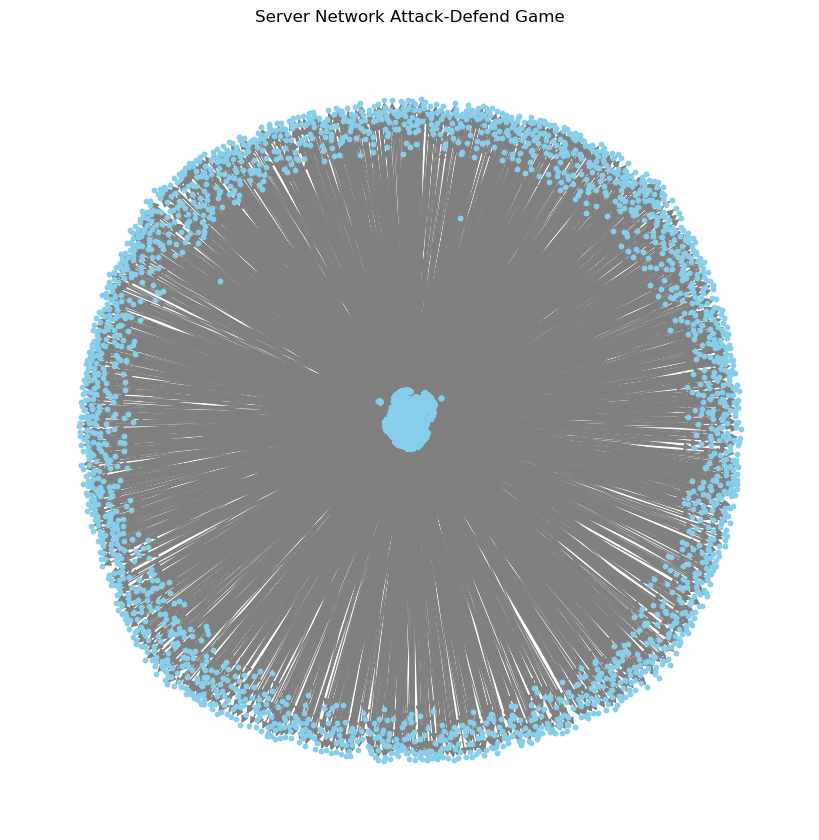

In [16]:
# Plot the graph with node IDs
plt.figure(figsize=(8, 8))
nx.draw(G, with_labels=False, node_color='skyblue', node_size=10, edge_color='gray', font_size=15, font_weight='bold')
plt.title('Server Network Attack-Defend Game')
plt.show()

Plot Server Network, add color to attack and victim nodes, the same apply for edges if they are attacks or benign

Add color to collateral victims too

In [17]:
# copy base dataset and filter the relevant interaction: if all interactions are BENIGN, or if at least one interaction is not BENIGN
base_last_interaction_df = base_df.copy()
base_last_interaction_df = base_last_interaction_df.groupby(by=['source_ip_index', 'destination_ip_index']).agg(interation_type=('label', lambda x: any(filter(lambda i: i != 'BENIGN', x)))).reset_index()
base_last_interaction_df = base_last_interaction_df.sort_values(by='interation_type').reset_index(drop=True)
base_last_interaction_df

,source_ip_index,destination_ip_index,interation_type
0,0,15418,False
1,12635,4802,False
2,12635,4801,False
3,12635,4799,False
4,12635,4797,False
...,...,...,...
113764,9035,15418,True
113765,10198,15879,True
113766,3292,9035,True
113767,15879,17330,True


In [18]:
base_last_interaction_df.loc[base_last_interaction_df['interation_type']]

,source_ip_index,destination_ip_index,interation_type
113754,7168,15879,True
113755,18801,996,True
113756,9035,3292,True
113757,17330,15879,True
113758,7723,15879,True
113759,15879,12635,True
113760,15879,10198,True
113761,15879,7723,True
113762,15879,7168,True
113763,12635,15879,True


In [19]:
edge_last_interaction_index = torch.tensor([base_last_interaction_df['source_ip_index'].tolist(), base_last_interaction_df['destination_ip_index'].tolist()], dtype=torch.long)
edge_last_interaction_index

tensor([[    0, 12635, 12635,  ...,  3292, 15879,  6838],
        [15418,  4802,  4801,  ...,  9035, 17330, 14801]])

In [20]:
# Create PyG Data object
last_interaction_data = Data(edge_index=edge_last_interaction_index, num_nodes=servers_df.shape[0])
# Convert the PyG data to a NetworkX graph for visualization
G_last_interaction = to_networkx(last_interaction_data, to_undirected=False)

In [21]:
# Define unique colors for each category using a colormap or a list of colors
unique_interaction_types = list(set(base_last_interaction_df['interation_type'])) 
color_map_interaction_types = dict(zip(unique_interaction_types, mcolors.TABLEAU_COLORS.keys()))

# Edge labels
edge_interation_types = base_last_interaction_df['interation_type'].tolist()

# Map the edge labels to their corresponding color
edge_colors = [color_map_interaction_types[label] for label in edge_interation_types]

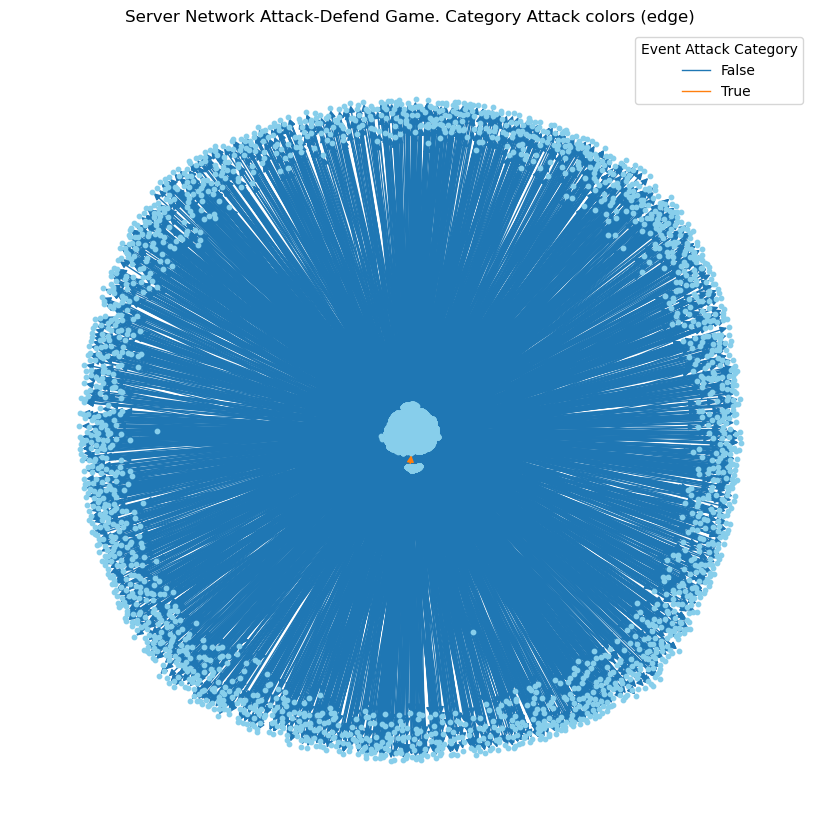

In [22]:
# Map IP addresses to integer node IDs
ip_to_id = {ip: idx for idx, ip in enumerate(pd.concat([base_last_interaction_df['source_ip_index'], base_last_interaction_df['destination_ip_index']]).unique())}

source_ids = base_last_interaction_df['source_ip_index'].map(ip_to_id).tolist()
destination_ids = base_last_interaction_df['destination_ip_index'].map(ip_to_id).tolist()

plt.figure(figsize=(8, 8))
# Get positions for the nodes
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=False, node_color='skyblue', node_size=10, edge_color=edge_colors, width=1, font_size=12, font_weight='bold')

# Annotate the edges with the actual label values
#edge_label_dict = {(source, target): f'{label}' for source, target, label in zip(source_ids, destination_ids, edge_labels)}
#nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_label_dict)

# Add a legend to show which color corresponds to which category
legend_labels = {color_map_interaction_types[label]: label for label in color_map_interaction_types}
handles = [plt.Line2D([0], [0], color=color, lw=1) for color in legend_labels.keys()]
plt.legend(handles, legend_labels.values(), title="Event Attack Category")

plt.title('Server Network Attack-Defend Game. Category Attack colors (edge)')
plt.show()

### 5. Calculate centrality metrics
Apply betweeness centrality and eigenvector centrality

In [23]:
from graphs_operations.operations import get_betweenness_centrality, get_eigenvector_centrality, get_graph_laplacian

Measures the extent to which a vertex lies on paths between other vertices. 

The business meaning in our case is the key communication servers, they may be good objectives to expand an attack and they are ket towers to defend

In [ ]:
nodes_betweenness_centrality_scores = get_betweenness_centrality(G)
node_centrality = [(servers_df.iloc[node], centrality) for node, centrality in nodes_betweenness_centrality_scores.items()]
node_centrality.sort(key=lambda x: x[1], reverse=True)
pd.DataFrame(node_centrality)

In [ ]:
server_ip = '192.168.10.12'
# server_ip = '192.168.10.5'
server_ip_index = servers_df.loc[servers_df['ip'] == server_ip].index[0]

in_degree = G.in_degree(server_ip_index)
out_degree = G.out_degree(server_ip_index)
print(f"The in-degree of server {server_ip} is: {in_degree}")
print(f"The out-degree of server {server_ip} is: {out_degree}")

Eigenvector centrality is a measure of the influence a node has on a network. 

The business meaning in our case is the influential servers, servers that could generate an influence over others.

In [ ]:
nodes_eigenvector_centrality_scores = get_eigenvector_centrality(G)
node_centrality = [(servers_df.iloc[node], centrality) for node, centrality in nodes_eigenvector_centrality_scores.items()]
node_centrality.sort(key=lambda x: x[1], reverse=True)
pd.DataFrame(node_centrality)

In [ ]:
server_ip = '192.168.10.15'
# server_ip = '192.168.10.5'
server_ip_index = servers_df.loc[servers_df['ip'] == server_ip].index[0]

in_degree = G.in_degree(server_ip_index)
out_degree = G.out_degree(server_ip_index)
print(f"The in-degree of server {server_ip} is: {in_degree}")
print(f"The out-degree of server {server_ip} is: {out_degree}")

Laplacian: Structure of the relations in a graph

In [ ]:
from torch_geometric.utils import to_networkx, get_laplacian
get_laplacian(edge_index)

In [ ]:
server_graph_data_filepath = './data/server_graph_data.pth'
torch.save(data, server_graph_data_filepath)